In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config

from runner import (
    run_vsem_experiment, 
    plot_coverage,
    plot_coverage_single_rep,
)

import vsem_jax as vsem
from vsem_inv_prob import (
    InvProb, 
    VSEMPrior, 
    VSEMLikelihood,
    VSEMTest
)

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../helpers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

config.update("jax_enable_x64", True)


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
sns.set_theme(style='white', palette='colorblind') # whitegrid
sns.set_context("paper", font_scale=1.5)

# Specific Paul Tol color scheme when comparing different posteriors
colors = {
    'exact': "#4477AA",
    'mean': "#EE6677",
    'eup': "#228833",
    'ep': "#CCBB44",
    'aux': "#888888"
}

## VSEM Experiment 1

In [3]:
rng = np.random.default_rng(6435)
n_design = 15
n_test_grid_1d = 50
n_reps = 2

tests, metrics, failed = run_vsem_experiment(rng=rng, 
                                             n_design=n_design, 
                                             n_reps=n_reps, 
                                             n_test_grid_1d=n_test_grid_1d)

Replication 1


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 63.902131
         Iterations: 86
         Function evaluations: 161
         Gradient evaluations: 147
Replication 2


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 77.170680
         Iterations: 106
         Function evaluations: 180
         Gradient evaluations: 169
Number of failed iterations: 0


In [4]:
# Exclude failed runs
tests = [x for i, x in enumerate(tests) if i not in failed]
metrics = [x for i, x in enumerate(metrics) if i not in failed]

print(f'Number of replicates remaining: {len(tests)}')

Number of replicates remaining: 2


TypeError: list indices must be integers or slices, not str

In [5]:
# Assumed constrant across all replications
probs = metrics[0]['alphas']

n_reps = len(tests)
n_probs = len(probs)
mean_coverage = np.empty((n_reps, n_probs))
eup_coverage = np.empty((n_reps, n_probs))
ep_coverage = np.empty((n_reps, n_probs))

# assemble arrays of coverage stats
for i, results in enumerate(metrics):
    mean, eup, ep = results['coverage']
    mean_coverage[i,:] = mean
    eup_coverage[i,:] = eup
    ep_coverage[i,:] = ep

In [6]:
q_min = 0.5
q_max = 0.95

# summarize distribution over replications
mean_m = np.median(mean_coverage, axis=0)
eup_m = np.median(eup_coverage, axis=0)
ep_m = np.median(ep_coverage, axis=0)
mean_q = np.quantile(mean_coverage, q=[q_min, q_max], axis=0)
eup_q = np.quantile(eup_coverage, q=[q_min, q_max], axis=0)
ep_q = np.quantile(ep_coverage, q=[q_min, q_max], axis=0)

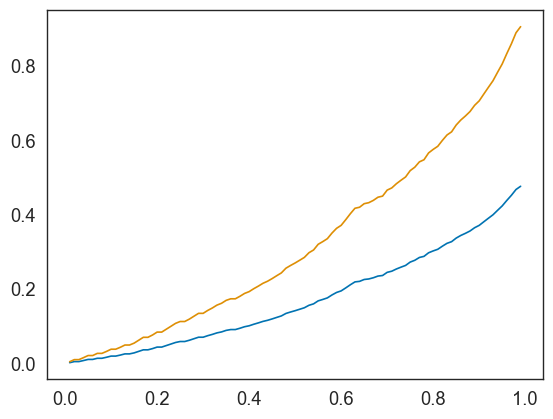

In [7]:
plt.plot(probs, mean_q[0])
plt.plot(probs, mean_q[1])
plt.show()

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/experiments/vsem/runner.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


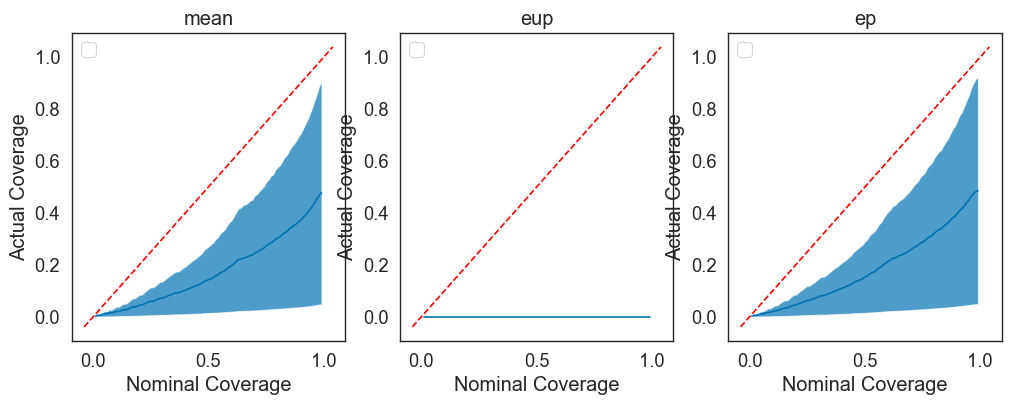

In [8]:
qmin = 0.05
qmax = 0.95

fig, ax = plot_coverage(tests, metrics, q_min=qmin, q_max=qmax)
# fig.savefig(f"out/coverage1_{qmin}_{qmax}.png")
display(fig)

In [ ]:
for i, metric in enumerate(metrics):
    print(f"Replicate {i}")
    coverage_list = metric['coverage']
    alphas = metric['alphas']
    fig = plot_coverage_single_rep(alphas, coverage_list, labels=['mean', 'eup', 'ep'])
    display(fig)

### Looking at one of the replicates

In [ ]:
rep_idx = 8

test = tests[rep_idx]
metric = metrics[rep_idx]
inv_prob = test.inv_prob

In [ ]:
inv_prob.likelihood.plot_driver()
plt.close()

In [ ]:
inv_prob.likelihood.plot_ground_truth()

In [ ]:
# GP predictions

fig_gp, axs_gp = test.plot_gp_pred(conditional=True, pred_type='pred', markersize=8)
fig_gp.savefig(f'out/gp_pred_rep{rep_idx}.png')
display(fig_gp)
plt.close()

In [ ]:
# Comparing posteriors
fig_log, axs_log = test.plot_posterior_comparison(shared_scale=False, log_scale=True,
                                                  pred_type='pred', nrows=2, figsize=(10,8))
fig, axs = test.plot_posterior_comparison(shared_scale=False, log_scale=False, 
                                          pred_type='pred', nrows=2, figsize=(10,8))

fig_log.savefig(f'out/post_comparison_logscale_rep{rep_idx}.png')
fig.savefig(f'out/post_comparison_rep{rep_idx}.png')
display(fig_log)
display(fig)
plt.close()

In [ ]:
# Surrogate bias 

fig_bias, ax_bias = test.plot_gp_bias(conditional=True, pred_type='pred')

fig_bias.savefig(f'out/gp_bias_rep{rep_idx}.png')
display(fig_bias)
plt.close()

In [ ]:
# Coverage plot

coverage_list = metric['coverage']
alphas = metric['alphas']

fig = plot_coverage_single_rep(alphas, coverage_list, labels=['mean', 'eup', 'ep'])
fig.savefig(f'out/coverage_rep{rep_idx}.png')
display(fig)

In [ ]:
# Sample exact posterior
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=20000)

display(trace_plot)
plt.close()

In [ ]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*inv_prob.likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()
plt.close()

In [ ]:
"""
log_dens_obs = lambda pred_obs: vsem_test.inv_prob.likelihood._likelihood_rv.log_p(pred_obs)
gpwrapped = gpjaxGP(vsem_test.gp_posterior, vsem_test.design, rng)
u_init = vsem_test.inv_prob.prior.sample()

rkpcn = RandomKernelPCNSampler(log_density=log_dens_obs,
                               gp=gpwrapped,
                               u_init=u_init,
                               u_prop_cov=proposal_cov,
                               pcn_cor=0.99,
                               rng=rng)

rkpcn.sample(num_steps=100)


n_samp = len(rkpcn.trace)
u_samp = np.empty((n_samp, prior.dim))
fu_samp = np.empty(n_samp)

for i, state in enumerate(rkpcn.trace):
    u_samp[i] = state.primary['u']
    fu_samp[i] = state.primary['fu'].squeeze()
"""

In [ ]:
import numpy as np
from coverage_plot import _example_run

In [ ]:
_example_run()